# Financial Econometrics: Empirical Analysis #2 and #3

### Setup environement

In [18]:
# basic libs
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# stats libs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM, select_coint_rank
from statsmodels.tsa.stattools import grangercausalitytests


# import yahoo finance to collect stocks data
import yfinance as yf
from fredapi import Fred

import warnings
warnings.filterwarnings("ignore")

### Import Data
Regarding the period we chose the following period: from 2012-12-31 to 2022-12-31.

We chose to use the FRED API to download to dowload the inflation rate financial time series (T10YIE).

Then we chose to use the Yahoo Finance API to collect stocks data from the FedEx company and oil market prices. FedEx Corporation is an American company and airline specializing in international freight transport. The ticker is of the stocks market FedEx company isFDX and the ticker of the oil stocks makret is (CL=F).

Our objective is to analyze the impact of oil prices and inflation on the market price of an international logistics/freight transport company whose main raw material is oil.

In summary we have 2 stocks prices time series (Oil and FedEx company) and one macroeconomic time series (inflation rate)

In [2]:
start_date = "2012-12-31"
end_date = "2022-12-31"
tickers = ["FDX", "CL=F"]

# Get data from Yahoo Finance
def get_YF_series(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data


# Get data from FRED :
def get_FRED_series(ticker):
    FRED_API_KEY = "9a54ab68d82273ea59014b16364b5bdd"
    fred = Fred(api_key=FRED_API_KEY)
    data = fred.get_series(ticker)
    data = data.dropna()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    return data

df_stocks = get_YF_series(tickers, start_date, end_date)

df_inflation_rate = get_FRED_series("T10YIE")


df_series=pd.merge(df_stocks,df_inflation_rate, how='inner', left_index=True, right_index=True)
df_series = df_series.rename(columns={0:"inflation_rate"})
df_series

[*********************100%%**********************]  2 of 2 completed


,CL=F,FDX,inflation_rate
2012-12-31,91.820000,80.759117,2.45
2013-01-02,93.120003,82.986763,2.48
2013-01-03,92.919998,83.294922,2.46
2013-01-04,93.089996,83.567902,2.48
2013-01-07,93.190002,83.400604,2.52
...,...,...,...
2022-12-23,79.559998,172.305984,2.20
2022-12-27,79.529999,173.402924,2.26
2022-12-28,78.959999,169.485306,2.28
2022-12-29,78.400002,171.933823,2.27


### Plotting the time series with daily frequency

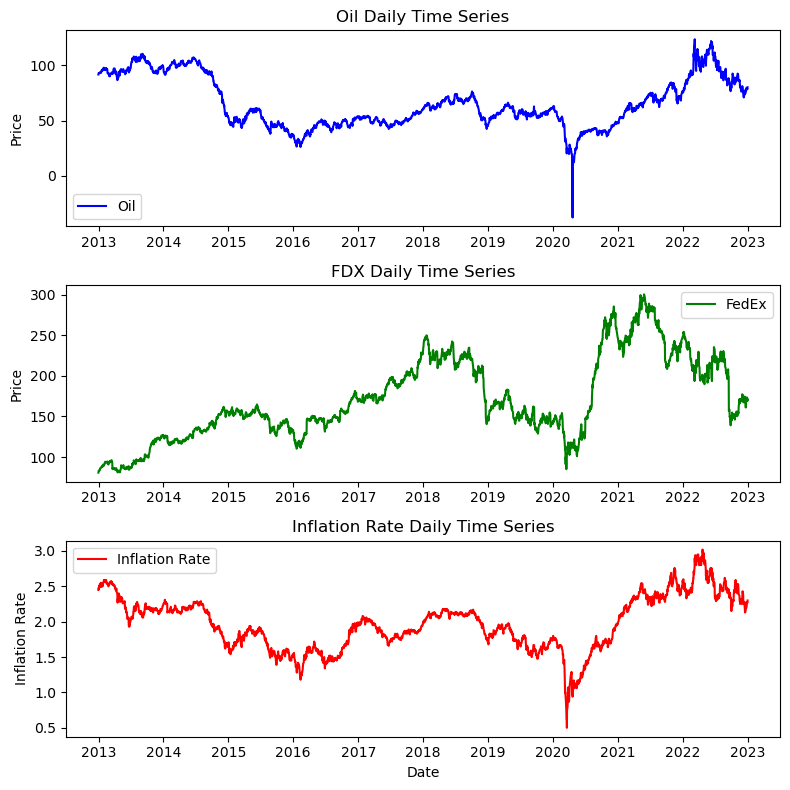

In [3]:
# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

# Plot resampled time series on each subplot
ax1.plot(df_series.index, df_series['CL=F'], linestyle='-', color='b', label='Oil')
ax1.set_title('Oil Daily Time Series')
ax1.set_ylabel('Price')
ax1.legend()

ax2.plot(df_series.index, df_series['FDX'], linestyle='-', color='g', label='FedEx')
ax2.set_title('FDX Daily Time Series')
ax2.set_ylabel('Price')
ax2.legend()

ax3.plot(df_series.index, df_series['inflation_rate'], linestyle='-', color='r', label='Inflation Rate')
ax3.set_title('Inflation Rate Daily Time Series')
ax3.set_xlabel('Date')
ax3.set_ylabel('Inflation Rate')
ax3.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

We can see firstly that the Inflation Rate and Oil price are very correlated

### Tranform the time series into `log` 

In [4]:
df_series_log = np.log(df_series)
df_series_log.isna().any()

CL=F               True
FDX               False
inflation_rate    False
dtype: bool

We have `NaN` value(s) for the `CL=F` series. We we fill NaN value by the previous value.

In [5]:
# Fill NaN with the previous value
df_series_log['CL=F'].fillna(method='ffill', inplace=True)
df_series_log

,CL=F,FDX,inflation_rate
2012-12-31,4.519830,4.391471,0.896088
2013-01-02,4.533889,4.418681,0.908259
2013-01-03,4.531739,4.422388,0.900161
2013-01-04,4.533567,4.425659,0.908259
2013-01-07,4.534640,4.423656,0.924259
...,...,...,...
2022-12-23,4.376511,5.149272,0.788457
2022-12-27,4.376134,5.155618,0.815365
2022-12-28,4.368941,5.132766,0.824175
2022-12-29,4.361824,5.147110,0.819780


### Plotting the three time series after the log transformation

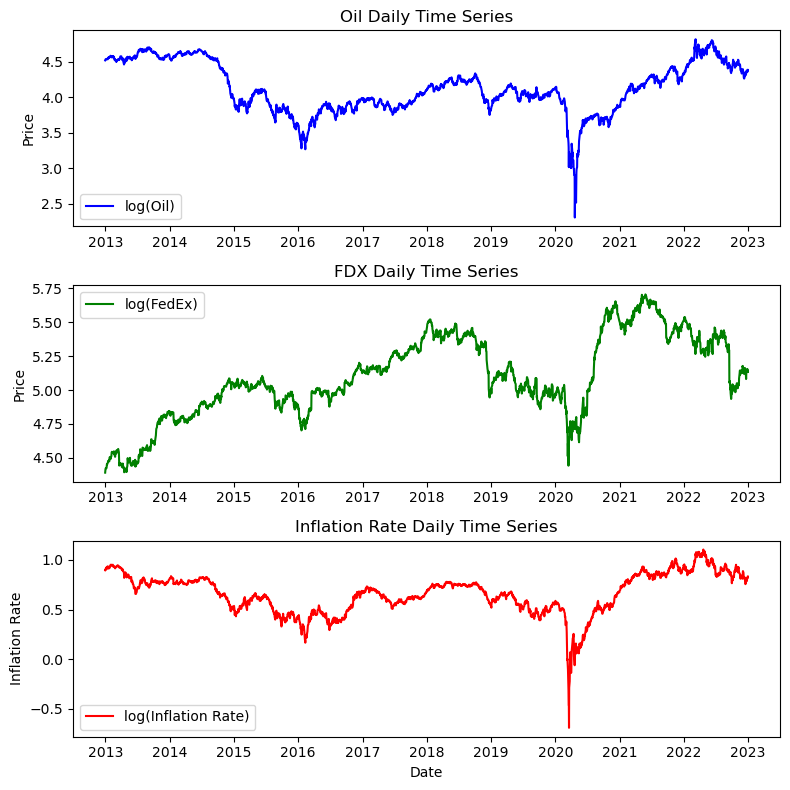

In [6]:
# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

# Plot resampled time series on each subplot
ax1.plot(df_series_log.index, df_series_log['CL=F'], linestyle='-', color='b', label='log(Oil)')
ax1.set_title('Oil Daily Time Series')
ax1.set_ylabel('Price')
ax1.legend()

ax2.plot(df_series_log.index, df_series_log['FDX'], linestyle='-', color='g', label='log(FedEx)')
ax2.set_title('FDX Daily Time Series')
ax2.set_ylabel('Price')
ax2.legend()

ax3.plot(df_series_log.index, df_series_log['inflation_rate'], linestyle='-', color='r', label='log(Inflation Rate)')
ax3.set_title('Inflation Rate Daily Time Series')
ax3.set_xlabel('Date')
ax3.set_ylabel('Inflation Rate')
ax3.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

After log transformation, we can visually see that the time series appear to follow a stochastic process. Time series appear to follow a stochastic process. They seem to follow random fluctuations, irregular patterns and no clear trend or seasonality. The data therefore appear erratic and may suggest a stochastic process.

### Perform a ADF test

We well perform an ADF test in order to test the presence of an unit root for each series.

To do so we consider the following hypothesis in the right order:


$\Delta X_t = b_0 + \rho X_{t-1} + \sum_{j=1}^{p-1} \phi_j \delta X_{t-j}+\epsilon_t$

**REGRESSION: CONSTANT AND TREND**
By performing this test, we assummes that the time series has a deterministic constant offset and a linear trend

Test for deterministic trend:
* $H_0:$ The trend coefficient is not signiciant ($b_1=0$)
* $H_1:$ The trend coefficient is signiciant ($b_1 \neq 0$)

If $H_0$ is rejected we accept $H1$ and check the presence of unit root
Test for unit root with trend:
* $H_0$: There is a unit root (i.e. $\rho \neq 0$ non stationarity) with a significant trend. The time series is non-stationary with deterministic trend.
* $H_1$: There is no unit root (i.e. $\rho = 0$ stationarity) no stochastic trend but a determistic trend.

If $H_0$ don't rejected ($b_1$ is not signicant) we have to turn the regression with constant (without trend)

**REGRESSION: CONSTANT**
By performing this test, we assummes that the time series has a deterministic constant offset but does not consider any trend.

Test for constant:
* $H_0:$ The constant coefficient is not significant ($b_0 = 0$)
* $H_1:$ The constant coefficient is significant ($b_0 \neq 0$)

If $H_0$ is rejected, we accept $H_1$ (i.e $b_0$ is significant $b_0 \neq 0$) and test the presence of unit root with constant:

* $H_0$: There is a unit root (i.e. $\rho \neq 0$ non stationarity) with a significant constant. The series is a random walk with a drift
* $H_1$: There is no unit root (i.e. $\rho = 0$ stationarity) and no sginificant constant

If $H_0$ don't rejected (i.e $b_0$ is not significant $b_0 = 0$) we have to turn the third regression with no constant and no trend and test direclty if the presence of a unit root.

**REGRESSION: NO CONSTANT AND NO TREND**
By performing this test, we assummes that the time series does not have a deterministic constant offset or trend components.

* $H_0$: There is a unit root (i.e. non stationarity). The series is a random walk
* $H_1$: There is no unit root (i.e. stationarity)

The p-value is the probability to wrongly reject $H_0$

If the p-value are lower than the threshold 5%, hence we can reject the null hypothesis $H_0$ and accept $H_1$ and affirm that the time series is likely stationary

Otherwise we fail to reject the null hypothesis $H_0$ and don't accept $H_1$ and affirm that the time series may be non-stationary

In [7]:
def adf_test(series):
    """
    ADFULLER Parameter
    -'c' : constant only (default) (random-walk with a drift)
    -'ct' : constant and trend. (both series could have been trend stationary)
    -'ctt' : constant, and linear and quadratic trend.
    -'n' : no constant, no trend (random walk)
    For example:
    - imposing 'n' to regression mean that we assume a random walk
    - imposing 'c' means you assume a random walk with a drift
    """
    print("______________________________")
    print("REGRESSION : CONSTANT AND TREND")
    print("______________________________")
          
    adf_ct_result = adfuller(series, regression = "ct")       
    
    adf_statistic_ct = adf_ct_result[0]
    p_value_ct = adf_ct_result[1]
    critical_values = adf_ct_result[4]
    
    print(f'ADF Statistic: {adf_statistic_ct}')
    print(f'p-value for the trend: {p_value_ct}')
    print("")
    
    if p_value_ct <= 0.05:
        print("Trend coefficient is sginificatif " + str(p_value_ct) + " < 0.05")
        print("We reject H0 (The trend coefficient is not signiciant (𝑏1=0) and accept H1 (𝑏0≠0)")
        if adf_statistic_ct < critical_values['5%']:
            print("ADF test with Constant and Trend: adf_statistic=" + str(adf_statistic_ct) + " <" + str(critical_values['5%']) + " Reject the null hypothesis H0, we accept H1 at 95% confidence level.") 
            print("The time series is likely stationary but a determistic trend")
            return
        else:
            print("ADF test with Constant and Trend: p-adf_statistic=" + str(adf_statistic_ct) + " >" + str(critical_values['5%']) + " Fail to reject the null hypothesis H0 we can't accept H1 at 95% confidence level.") 
            print("The time series may be non-stationary. There is a presence of a unit root and deterministic trend.")
            print("The time series is non-stationary with trend")
            return
    else:
        print("Trend coefficient is not sginificatif " + str(p_value_ct) + " > 0.05")
        print("We fail to reject H0 (The trend coefficient is not signiciant (𝑏1=0)")
        print("We turn to the second REGRESSION WITH CONSTANT")
          
    
    print("\n______________________________")
    print("REGRESSION : CONSTANT")
    print("______________________________") 
          
    adf_c_result = adfuller(series, regression = "c")
    # Extract ADF test statistics and p-value
    p_value_c = adf_c_result[1]
    critical_values = adf_c_result[4]
    adf_statistic = adf_c_result[0]
                  
    print(f'ADF Statistic: {adf_statistic}')              
    print(f'p-value for the constant: {p_value_c}')
                  
    if p_value_c <= 0.05:
        print('The constant coefficient is significant (𝑏0≠0)')
        print("ADF test with Constant: p-value=" + str(p_value_c) + " < 0.05. Reject the null hypothesis H0, we accept H1 at 95% confidence level.") 
        print("The constant coefficient is not significant")
        if adf_statistic < critical_values['5%']:
            print("ADF test with Constant: adf_statistic=" + str(adf_statistic) + " <" + str(critical_values['5%']) +" Reject the null hypothesis H0, we accept H1 at 95% confidence level.") 
            print("The time series is stationary with a constant")
            return
        else:
            print("ADF test with Constant: adf_statistic=" + str(adf_statistic) + " >" + str(critical_values['5%']) + " Fail to reject the null hypothesis H0 we can't accept H1 at 95% confidence level.") 
            print("The time series may be non-stationary. There is a presence of a unit root and significant constant.")
            print("The series is a random walk with a drift (i.e constant)")
            return
    else:
        print('The constant coefficient is not significant (𝑏0=0)')
        print("ADF test with Constant: p-value=" + str(p_value_c) + " > 0.05.")
        print("We fail to reject the null hypothesis H0 (b0=0)") 
        print("We turn to the third REGRESSION WITH NO CONSTANT AND NO TREND and test the presence of UR")

    print("\n______________________________")
    print("REGRESSION : NO CONSTANT AND NO TREND")
    print("______________________________") 
          
    adf_n_result = adfuller(series, regression = "n")
    # Extract ADF test statistics and p-value
    p_value_n = adf_n_result[1]
                  
    if p_value_c <= 0.05:
        print("ADF test with No Constant and No Trend: p-value=" + str(p_value_n) + " < 0.05. Reject the null hypothesis H0, we accept H1 at 95% confidence level.")
        print("The time series is likely stationary without trend and constant.")
    else:
        print("ADF test with No Constant and No Trend: p-value=" + str(p_value_n) + " > 0.05. Fail to reject the null hypothesis H0, we can't accept H1 at 95% confidence level.")
        print("The time series may be non-stationary. There is a presence of a unit root and stochastic trend.")
        print("The time series is a random walk without constant and deterministic trend")
        
print("###########################################")
print("ADF TEST: OIL SROCK PRICES  (log(CL=F))")
print("###########################################\n")
adf_test(df_series_log['CL=F'])

print("\n\n###########################################")
print("ADF TEST: FedEx STOCK PRICES (log(FXD)) ")
print("###########################################\n") 
adf_test(df_series_log['FDX'])

print("\n\n###########################################")
print("ADF TEST: INFLATION RATE (log(inflation_rate)) ")
print("###########################################\n") 
adf_test(df_series_log['inflation_rate'])

###########################################
ADF TEST: OIL SROCK PRICES  (log(CL=F))
###########################################

______________________________
REGRESSION : CONSTANT AND TREND
______________________________
ADF Statistic: -2.4569387154315274
p-value for the trend: 0.3498148230685654

Trend coefficient is not sginificatif 0.3498148230685654 > 0.05
We fail to reject H0 (The trend coefficient is not signiciant (𝑏1=0)
We turn to the second REGRESSION WITH CONSTANT

______________________________
REGRESSION : CONSTANT
______________________________
ADF Statistic: -2.5342535929265395
p-value for the constant: 0.10736090751335386
The constant coefficient is not significant (𝑏0=0)
ADF test with Constant: p-value=0.10736090751335386 > 0.05.
We fail to reject the null hypothesis H0 (b0=0)
We turn to the third REGRESSION WITH NO CONSTANT AND NO TREND and test the presence of UR

______________________________
REGRESSION : NO CONSTANT AND NO TREND
______________________________
ADF

### Plot ACF and PACF for each time series without differencing

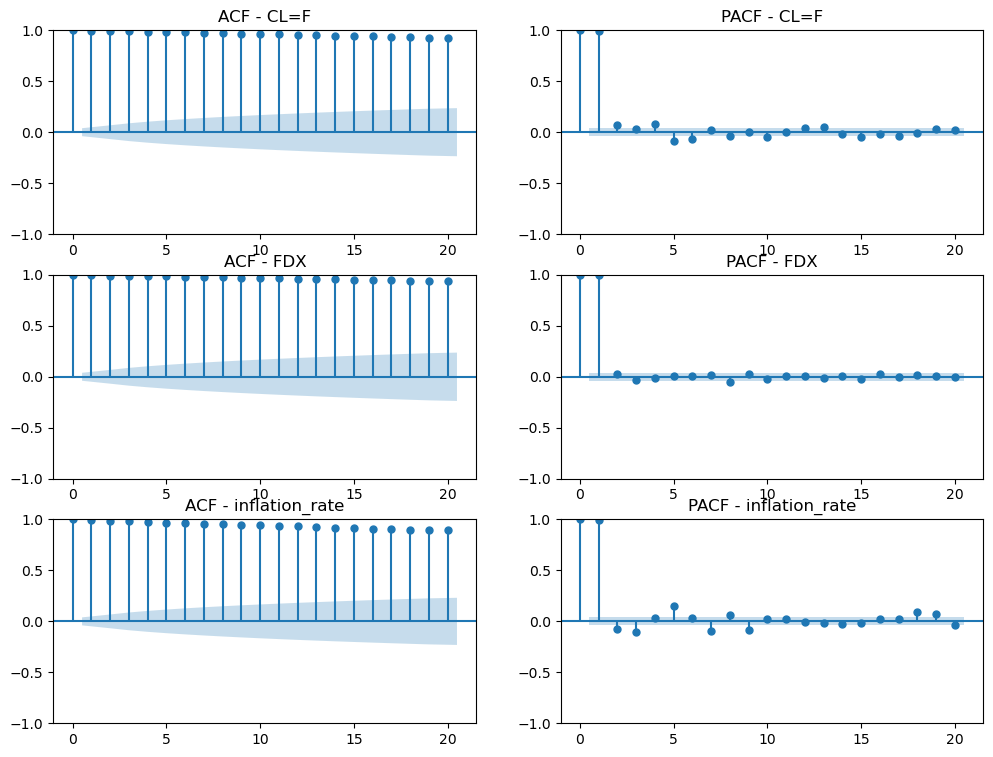

In [8]:
# Plot ACF and PACF for each time series
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))

for i, col in enumerate(df_series_log.columns):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]

    # Plot ACF
    plot_acf(df_series_log[col], lags=20, ax=ax1)
    ax1.set_title(f'ACF - {col}')

    # Plot PACF
    plot_pacf(df_series_log[col], lags=20, ax=ax2)
    ax2.set_title(f'PACF - {col}')

We can see that the ACF values are close to 1 at lags 1 to 20. This indicate a very strong positive correlation between the current value and the previous 20 values. In other words, the time series is highly correlated with its recent past. This suggests a strong memory or persistence in the data. In fact, the ACF values are high and decrease very, very slowly, this is a sign that the data are not stationary, so they need to be differentiated. But before to take the first difference we will perform a ADF test to test the presence of an unit root for each time series

## For this Empirical Application we will jointly work on the Empirical Application 2 and Empirical Application 3 at the same time

To do so we will follow the following strategy:

**1- Cointegration Johansen rank test**

* If there is no cointegration, turn to a VAR model with first differences of the I(1) components
    * Order of the VAR
    * Estimation
    * Causality tests
    
    
* If we validate cointegration, we will  consider the VAR without differencing the I(1) components and apply a VAR in level and VECM model:
    * For VAR in level
        * Estimation
        * Causality tests
        
    * For VECM
        * Apply a VECM model
        * Apply Causality test
        * Plot impulse response function

### Cointegration test

Cointegrated time series refer to a set of multiple time series variables that exhibit a long-term or equilibrium relationship with each other, even though individually, they may be non-stationary. In other words, cointegration is a statistical property that allows multiple non-stationary time series to move together in the long run, despite potentially having short-term fluctuations and trends. From a more mathematical point of view, cointegration implies that a linear combination of non-stationary time series variables results in a stationary time series. While individual variables may not be stationary, there exists a combination of them that is stationary.

Cointegration implies that there is a stable, long-term relationship among the variables. This means that any short-term deviations from this relationship will be corrected over time, and the variables will return to their equilibrium.

In fact, cointegration is commonly used in economics and finance. For example, in finance, it's applied to pairs trading, where two or more assets that are cointegrated are traded against each other. In economics, cointegrated variables might represent different economic indicators like inflation and unemployment, which should theoretically move together in the long run.

To test if our 3 series are conintegrated we will apply The Johansen cointegration test. The Johansen cointegration test is a statistical method used to determine the presence and number of cointegrating relationships among a set of time series variables. Cointegration is a crucial concept in time series analysis, particularly in the context of multivariate data, where variables may exhibit long-term relationships even if they are not individually stationary.

The hypothesis of the Johansen cointegration test are :
* $H_0$: there are at most $r$ cointegrating relationships in the system, where $r$ is less than or equal to the number of variables $K$.
* $H_1$: there are more than $r$ cointegrating relationships in the system, suggesting a higher degree of long-term dependencies among the variables.

The rank $r$ is a measure of how many linearly independent cointegrating relationships exist among the variables. If the computed test statistics exceed the critical values, the null hypothesis $H_0$ is rejected in favor of the alternative hypothesis, indicating the presence of cointegration and providing insights into the number of cointegrating relationships in the system. In fact, Rejecting the null hypothesis suggests that there is evidence of cointegration, implying that there are linear combinations of the variables that result in stationary relationships.

In [24]:
def coint_rank_johansen_test(df, det_order, k_ar_diff):
    # Perform Johansen cointegration test
    result = coint_johansen(df, det_order=det_order, k_ar_diff=k_ar_diff)

    # Extract critical values for the test statistics
    trace_stat_crit_vals = result.cvm[:, 0]
    max_eig_stat_crit_vals = result.cvm[:, 1]

    # Extract the test statistics and compare with critical values
    trace_stat = result.lr1
    max_eig_stat = result.lr2

    # Determine the rank (number of cointegrating relationships)
    rank = np.sum(trace_stat > trace_stat_crit_vals)

    print("==== Results Johansen cointegration test ====")
    # Print results
    print(f"Trace Statistic at [90%, 95%, 99%] Confidence Level: {trace_stat}")
    print(f"Max Eigenvalue Statistic at [90%, 95%, 99%] Confidence Level: {max_eig_stat}")
    print(f"Critical Values for Trace Statistic: {trace_stat_crit_vals}")
    print(f"Critical Values for Max Eigenvalue Statistic: {max_eig_stat_crit_vals}")
    print(f"Rank (Number of Cointegrating Relationships): {rank}")
    
    # Check if we reject the null hypothesis
    alpha = 0.05  # Significance level
    reject_null_trace = any(trace_stat > trace_stat_crit_vals)
    reject_null_max_eig = any(max_eig_stat > max_eig_stat_crit_vals)

    print("\n\n==== Hypoyhesis Testing ====")
    if reject_null_trace or reject_null_max_eig:
        print("For significance level:", alpha)
        print("Reject the null hypothesis: There is evidence of cointegration.")
    else:
        print("For significance level:", alpha)
        print("Fail to reject the null hypothesis: No evidence of cointegration.")
    
    print("\n\n==== Coefficient Cointegration Relationships ====")
    # Extract cointegrating vectors (coefficients)
    coint_vectors = result.evec
    # Print the cointegrating vectors
    print("Cointegrating Vectors:")
    print(coint_vectors)

    # Interpret the signs of the coefficients
    for i in range(rank):
        print(f"\nCointegrating Relationship {i+1}:")
        for j in range(df.shape[1]):
            print(f"Coefficient for {df.columns[j]}: {coint_vectors[j, i]:.4f}")
    
    print("\n\n#### COINTEGRATION TEST SUMMARY ####")
    print("Johansen cointegration test using trace test statistic with 95% significance level")
    
    rank_test = select_coint_rank(df, det_order=det_order, k_ar_diff=k_ar_diff, method="trace",
                              signif=0.05)
    return rank_test

rank_test = coint_rank_johansen_test(df_series_log, det_order=0, k_ar_diff=1)
rank_test.summary()

==== Results Johansen cointegration test ====
Trace Statistic at [90%, 95%, 99%] Confidence Level: [59.63449898 14.23244051  5.4821261 ]
Max Eigenvalue Statistic at [90%, 95%, 99%] Confidence Level: [45.40205848  8.7503144   5.4821261 ]
Critical Values for Trace Statistic: [18.8928 12.2971  2.7055]
Critical Values for Max Eigenvalue Statistic: [21.1314 14.2639  3.8415]
Rank (Number of Cointegrating Relationships): 3


==== Hypoyhesis Testing ====
For significance level: 0.05
Reject the null hypothesis: There is evidence of cointegration.


==== Coefficient Cointegration Relationships ====
Cointegrating Vectors:
[[  6.38836158   0.47221971   2.55381436]
 [  2.94745815  -3.27971917   0.86930429]
 [-12.51877628   0.2647839    0.40605833]]

Cointegrating Relationship 1:
Coefficient for CL=F: 6.3884
Coefficient for FDX: 2.9475
Coefficient for inflation_rate: -12.5188

Cointegrating Relationship 2:
Coefficient for CL=F: 0.4722
Coefficient for FDX: -3.2797
Coefficient for inflation_rate: 0.26

r_0,r_1,test statistic,critical value
0,3,59.63,29.80
1,3,14.23,15.49


#### Interpretation:

**Trace Statistic:**

The trace statistic is a test statistic associated with the null hypothesis that there are at most $r$ cointegrating relationships in the system. The larger the trace statistic, the more evidence there is against the null hypothesis. This statistic is compared to critical values to make decisions regarding the presence of cointegration.

**Max Eigenvalue Statistic:**

The maximum eigenvalue statistic is another test statistic associated with the null hypothesis. It specifically tests whether there are exactly $r$ cointegrating relationships. Like the trace statistic, a larger value indicates stronger evidence against the null hypothesis.

**Critical Values for Trace Statistic:**

These are the critical values associated with the trace statistic. Critical values are thresholds beyond which you would reject the null hypothesis. The trace statistic is compared to these critical values to determine whether to reject the null hypothesis of at most $r$ cointegrating relationships.

**Critical Values for Max Eigenvalue Statistic:**

Similar to the trace statistic, these are the critical values associated with the max eigenvalue statistic. They serve as thresholds for rejecting the null hypothesis of exactly $r$ cointegrating relationships.

**Rank (Number of Cointegrating Relationships):**

The rank is the number of cointegrating relationships suggested by the test. It is determined based on the trace statistic and critical values. The rank gives insights into the long-term relationships among the variables.

### Comment about the Cointegration Test results

In summary, we can see, that trace statistics and max eigen value statistic are higher compared to their respective critical values at 90%, 95% and 99% confidence level. 

For example, In our case, both the trace statistic (59.6345) and the max eigenvalue statistic (45.4020) exceed the critical values at the 95% confidence level (18.8928 for trace and 21.1314 for max eigenvalue).

This results suggests evidence against the null hypothesis $H_0$, indicating the presence of cointegration. Hence, we reject the null Hypothesis $H_0$.

We conclude that, we have evidence to support the presence of cointegration among the variables. This implies that there are linear combinations of these variables that result in stationary relationships, providing a long-term connection among them. This information is valuable for understanding the underlying structure and dynamics of your multivariate time series data.

### Comment of the sign of cointegration coefficient

The signs of the coefficients indicate the direction and strength of the relationships in each cointegrating combination. Interpretation may depend on the context of your data and the specific economic or financial factors represented by the variables. Positive coefficients imply positive relationships, while negative coefficients imply negative relationships.

To comment the sign of we will discuss and go through the 3 cointegrating relationship

**Cointegrating Relationship 1:**

* **CL=F (Crude Oil Futures):** The positive coefficient (6.3884) suggests a positive relationship with the cointegrated combination. An increase in CL=F is associated with an increase in this cointegrating relationship.

* **FDX (FedEx Stock):** The positive coefficient (2.9475) indicates a positive relationship. An increase in FDX is associated with an increase in this cointegrating relationship.

* **Inflation Rate:** The negative coefficient (-12.5188) suggests a negative relationship. An increase in the inflation rate is associated with a decrease in this cointegrating relationship.

This cointegrating relationship seems to capture a combination of economic factors where the price of crude oil futures and FedEx stock move in the same direction, while the inflation rate moves in the opposite direction.

**Cointegrating Relationship 2:**

* **CL=F (Crude Oil Futures):** The positive coefficient (0.4722) suggests a positive relationship with the second cointegrating combination.

* **FDX (FedEx Stock):** The negative coefficient (-3.2797) indicates a negative relationship.

* **Inflation Rate:** The positive coefficient (0.2648) suggests a positive relationship.

Findings: This relationship implies a combination where the price of crude oil futures and the inflation rate move in the same direction, while the movement of FedEx stock is in the opposite direction.

**Cointegrating Relationship 3:**

* **CL=F (Crude Oil Futures):** The positive coefficient (2.5538) suggests a positive relationship with the third cointegrating combination.

* **FDX (FedEx Stock):** The positive coefficient (0.8693) indicates a positive relationship.

* **Inflation Rate:** The positive coefficient (0.4061) suggests a positive relationship.

Findings: In this relationship, all three variables—crude oil futures, FedEx stock, and the inflation rate—move in the same direction.

It's important to note that cointegration analysis provides information about long-term relationships but does not imply causation.

Overall conclusion, our series a cointegrated. Therefore we will turn to VAR in level and VECM model 

## Applying VAR model in level

The Vector Autoregressive (VAR) model is a statistical time series model used in econometrics and other fields to analyze the dynamic relationships among multiple variables over time. It is an extension of the univariate autoregressive (AR) model to multivariate time series data. VAR models are particularly useful when the variables under consideration are interrelated and influence each other.

**Vector Notation**

$y_t$ denotes a vector on $K$ variables at time $t$. The VAR model deals with $p$-th order autoregressive processes, denotes as $VAR(p)$ where $p$ is the number of lags.

**Formulation**
* The general formula of a $VAR(p)$ model is given by:

$\mathbf{y}_t = \mathbf{c} + \sum_{i=1}^{p} \mathbf{A}_i \mathbf{y}_{t-i} + \mathbf{\varepsilon}_t
$

where:

* $y_t$ is the vector of time series variables at time $t$
* $c$ is a vector of constants
* $A_i$ represents the coefficient matrices for each lag $i$ from 1 to $p$
* $\epsilon_t$ is a vector of error terms assumed to be white noise

**Stationarity**

For the VAR model to be estimated and interpreted correctly, the time series variables involved should be stationary. This often requires differencing the variables.

### Estimate the order of the VAR model without differencing the series

Determining the appropriate order $p$ of the VAR model is crucial. Various criteria, such as Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC), are commonly used to select the optimal lag order.

In our case to estimate the best order we will loop over p order and choose the best order according the AIC and BIC criterions.

In [10]:
def select_VAR_order(df, nb_orders_tested=50):
    order_list = []
    for p in range(nb_orders_tested):
        model = VAR(df)
        results = model.fit(p)
        order_list.append((p, results.aic, results.bic))
    order_list = pd.DataFrame(order_list)
    order_list.columns = ["p", "AIC", "BIC"]
    order_list = order_list.sort_values(by=['BIC'],ascending=[True])
    print("TOP 5: Best orders")
    return order_list[:5]

select_VAR_order(df_series_log)

TOP 5: Best orders


,p,AIC,BIC
5,5,-22.869592,-22.757585
2,2,-22.801647,-22.752692
6,6,-22.884176,-22.751123
8,8,-22.925335,-22.750149
3,3,-22.817048,-22.747090


According to the AIC and BIC information criterion, we can see that the best order for the VAR model is lag $p = 5$.

### Estimate VAR model in Level

To do so we will set the lag $p$ oder at 5

In [11]:
order = 5
# Fit VAR model
model = VAR(df_series_log)
results = model.fit(order)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 09, Dec, 2023
Time:                     13:54:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -22.7576
Nobs:                     2495.00    HQIC:                  -22.8289
Log likelihood:           17957.1    FPE:                1.16913e-10
AIC:                     -22.8696    Det(Omega_mle):     1.14692e-10
--------------------------------------------------------------------
Results for equation CL=F
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.093446         0.024243            3.855           0.000
L1.CL=F                   0.885327         0.020752           42.662           0.000
L1.FDX                   -0.069098         0.

### Applying VECM

Based on the previous Johansen cointegration test we know that our 3 series are cointegrated. Therefore, we can apply a VECM model.

A VECM (Vector Error Correction Model) is a specialized form of a Vector Autoregressive (VAR) model used for analyzing and modeling the behavior of multiple, cointegrated time series variables. VECM models are particularly useful when dealing with non-stationary time series data and are commonly used in economics and finance.

VECM models are designed to capture both short-term dynamics and the long-term equilibrium relationships among the variables in the system. In other words, a VECM combines short-term deviations from equilibrium (measured by error terms) with the long-term equilibrium relationship.

The "Error Correction Term" is a crucial component of a VECM model. It represents the mechanism by which the variables return to their long-term equilibrium after experiencing short-term shocks or deviations. This term accounts for the cointegration among the variables and ensures that the model reflects the concept of mean reversion, where variables revert to their long-term relationship after temporary divergences.

**VECM Equation**

$\Delta \mathbf{Y}_t = \mathbf{\Pi} \mathbf{Y}_{t-1} + \sum_{i=1}^{p-1} \mathbf{\Gamma}_i \Delta \mathbf{Y}_{t-i} + \mathbf{A} \mathbf{D}_t + \mathbf{B} \mathbf{X}_{t-1} + \mathbf{u}_t$

where:

* $\Delta \mathbf{Y}_t$ is the matrix of first differences of the variables at time $t$
* $\mathbf{Y}_{t-1}$ is the lagged levels of the variables at time
* $\mathbf{\Pi}$ is the matrix of cointegrating vectors.
* $\mathbf{\Gamma}_i$ are the matrices of adjustment coefficients for the short-run dynamics.
* $A$ is a matrix that captures the impact of exogenous variables $D_t$, on the cointegrating relationship.
* $B$ captures the impact of lagged values of exogenous variables $X_{t-1}$ on the cointegrating relationship.
* $u_t$ is the error term

The cointegrating vectors $\Pi$ represent the long-term equilibrium relationships among the variables. These vectors are obtained from the Johansen cointegration test and indicate how the variables adjust to deviations from their long-term relationships.

The adjustment coefficients $\mathbf{\Gamma}_i$ represent the short-term dynamics that correct deviations from the long-term equilibrium. The matrices 
$A$ and $B$ capture the impact of exogenous variables on the cointegrating relationship.

In summary, the VECM is a powerful model for capturing both short-term and long-term relationships among cointegrated variables. It is widely used in econometrics and finance for modeling and forecasting.

In [12]:
def VECM_model(df):
    # Perform Johansen cointegration test to determine the cointegrating rank
    result = coint_johansen(df, det_order=0, k_ar_diff=1)
    # Extract critical values for the test statistics
    trace_stat_crit_vals = result.cvm[:, 0]
    max_eig_stat_crit_vals = result.cvm[:, 1]

    # Extract the test statistics and compare with critical values
    trace_stat = result.lr1
    max_eig_stat = result.lr2
    
    # Determine the rank (number of cointegrating relationships)
    rank = np.sum(trace_stat > trace_stat_crit_vals)

    # Create a VECM model
    vecm_model = VECM(df, k_ar_diff=1, coint_rank=rank)

    # Fit the VECM model
    vecm_result = vecm_model.fit()

    # Print the summary of the VECM model
    print(vecm_result.summary())
    
VECM_model(df_series_log)

 Det. terms outside the coint. relation & lagged endog. parameters for equation CL=F 
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.CL=F              -0.1035      0.020     -5.077      0.000      -0.143      -0.064
L1.FDX               -0.0659      0.032     -2.032      0.042      -0.129      -0.002
L1.inflation_rate     0.2080      0.032      6.573      0.000       0.146       0.270
  Det. terms outside the coint. relation & lagged endog. parameters for equation FDX 
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.CL=F              -0.0042      0.013     -0.323      0.746      -0.030       0.021
L1.FDX               -0.0368      0.021     -1.787      0.074      -0.077       0.004
L1.inflation_rate     0.0221      0.020      1.100    

#### Interpretation

* The VECM model captures both short-term dynamics (lagged variables) and long-term cointegrating relationships among CL=F, FDX, and inflation_rate.

* The negative coefficients of the lagged endogenous variables ($L1.CL=F, L1.FDX$)

* The error correction terms ($ec1,ec2, ec3$) and cointegration relations provide insights into how the variables adjust in the short term and are related in the long term. Negative values indicate a correction toward the long-term relationship in response to deviations.

### Look at the Granger causal links from the VECM model

The Granger Causality Test is a statistical hypothesis test used to determine whether one time series can predict another time series. In other words, it assesses whether one variable "Granger-causes" changes in another variable. 

**Concept of Causality:** In the context of the Granger Causality Test, "causality" does not imply a cause-and-effect relationship in the traditional sense. Instead, it assesses whether past values of one variable contain information that helps predict future values of another variable. It is essentially a way to measure predictive power.

**Direction of Causality:** It's important to note that the Granger Causality Test is not designed to establish the direction of causality. It only determines if there is a causal relationship in one direction (X to Y) or both directions. To determine the direction, additional tests or causal reasoning are often required.

**Two Variables:** The test involves two time series variables, often referred to as Y (the dependent variable) and X (the potential causal variable). You want to determine if X Granger-causes Y, meaning that past values of X can help predict future values of Y.

**Test Statistic:** 
* $H_0$ (Null Hypothesis): There is no Granger causality from the independent variable (X) to the dependent variable $Y$.
* $H_1$ (Alternative Hypothesis): There is Granger causality from the independent variable $X$ to the dependent variable $Y$

The test statistic often follows an F-distribution. The critical value is determined based on the desired significance level (alpha), and if the test statistic exceeds this critical value, the null hypothesis is rejected in favor of the alternative hypothesis.

In [13]:
def granger_causality_matrix(data, max_lag):
    num_variables = data.shape[1]
    p_values_matrix = np.zeros((num_variables, num_variables))

    variable_names = data.columns

    for i in range(num_variables):
        for j in range(num_variables):
            result = grangercausalitytests(data[[variable_names[i], variable_names[j]]], max_lag, verbose=False)
            p_value = result[max_lag][0]['ssr_ftest'][1]
            p_values_matrix[i, j] = round(p_value, 3)
            
    index_with_suffix = [name + '_x' for name in variable_names]
    columns_with_suffix = [name + '_y' for name in variable_names]
    
    p_values_df = pd.DataFrame(p_values_matrix, index=index_with_suffix, columns=columns_with_suffix)
    return p_values_df

#### Causality long term

To analyze the long term causality links we set number of lags at 10

In [14]:
max_lag = 10
# Call the function to get the p-value matrix as a DataFrame
p_values_df = granger_causality_matrix(df_series_log, max_lag)

# Display the p-value DataFrame
print("Long-term Granger Causality P-Value Matrix:")
p_values_df

Long-term Granger Causality P-Value Matrix:


,CL=F_y,FDX_y,inflation_rate_y
CL=F_x,1.000,0.001,0.0
FDX_x,0.511,1.000,0.0
inflation_rate_x,0.000,0.000,1.0


#### Long-term Causality test interpretation

**CL=F to FDX**

* The p-value is 0.001, which is less than the significance level of 0.05.
* Interpretation: There is evidence to reject the null hypothesis. The past values of CL=F Granger-cause FDX. In other words, past values of CL=F contain information that helps predict the current values of FDX.

**FDX to CL=F**

The p-value is 0.511, is really close to the significance level of 0.05.
Interpretation: But, from a strict point of view, there is insufficient evidence to reject the null hypothesis. The past values of FDX do not Granger-cause CL=F. In other words, past values of FDX do not contain information that helps predict the current values of CL=F. But as the p-value is really close to the the significance level of 5% we can also say that FDX contain information that helps predict the current values of CL=F 

**CL=F to Inflation Rate**

The p-value is 0.0, which is less than the significance level of 0.05.
Interpretation: There is evidence to reject the null hypothesis. The past values of CL=F Granger-cause inflation_rate. In other words, past values of CL=F contain information that helps predict the current values of inflation_rate.

**FDX to Inflation Rate**

The p-value is 0.0, which is less than the significance level of 0.05.
Interpretation: There is evidence to reject the null hypothesis. The past values of FDX Granger-cause inflation_rate. In other words, past values of FDX contain information that helps predict the current values of inflation_rate.

**Inflation Rate to CL=F**

The p-value is 0.0, which is less than the significance level of 0.05.
Interpretation: There is evidence to reject the null hypothesis. The past values of inflation_rate Granger-cause CL=F. In other words, past values of inflation_rate contain information that helps predict the current values of CL=F.

**Inflation Rate to FDX**

The p-value is 0.0, which is less than the significance level of 0.05.
Interpretation: There is insufficient evidence to reject the null hypothesis. The past values of inflation_rate Granger-cause FDX. In other words, past values of inflation_rate contain information that helps predict the current values of FDX.

#### Causality short term

In [15]:
max_lag = 1
# Call the function to get the p-value matrix as a DataFrame
p_values_df = granger_causality_matrix(df_series_log, max_lag)

# Display the p-value DataFrame
print("Short-term Granger Causality P-Value Matrix:")
p_values_df

Short-term Granger Causality P-Value Matrix:


,CL=F_y,FDX_y,inflation_rate_y
CL=F_x,1.000,0.517,0.00
FDX_x,0.286,1.000,0.22
inflation_rate_x,0.141,0.060,1.00


#### Short-term Causality test interpretation

**CL=F to FDX**

The p-value is 0.517, which is greater than the significance level of 0.05.
Interpretation: There is insufficient evidence to reject the null hypothesis. The past values of CL=F do not Granger-cause FDX. In other words, past values of CL=F do not contain information that helps predict the current values of FDX.

**FDX to CL=F**

The p-value is 0.286, which is greater than the significance level of 0.05.
Interpretation: There is insufficient evidence to reject the null hypothesis. The past values of FDX do not Granger-cause CL=F. In other words, past values of FDX do not contain information that helps predict the current values of CL=F.

**CL=F to Inflation Rate**

The p-value is 0.00, which is less than the significance level of 0.05.
Interpretation: There is evidence to reject the null hypothesis. The past values of CL=F Granger-cause inflation_rate. In other words, past values of CL=F contain information that helps predict the current values of inflation_rate.

**FDX to Inflation Rate**

The p-value is 0.060, which is greater than the significance level of 0.05.
Interpretation: There is insufficient evidence to reject the null hypothesis. The past values of FDX do not Granger-cause inflation_rate. In other words, past values of FDX do not contain information that helps predict the current values of inflation_rate.

**Inflation Rate to CL=F**

The p-value is 1.00, which is greater than the significance level of 0.05.
Interpretation: There is insufficient evidence to reject the null hypothesis. The past values of inflation_rate do not Granger-cause CL=F. In other words, past values of inflation_rate do not contain information that helps predict the current values of CL=F.

**Inflation Rate to FDX**

The p-value is 0.22, which is greater than the significance level of 0.05.
Interpretation: There is insufficient evidence to reject the null hypothesis. The past values of inflation_rate do not Granger-cause FDX. In other words, past values of inflation_rate do not contain information that helps predict the current values of FDX.

In summary, these results suggest that there is Granger causality from CL=F to inflation_rate, but no Granger causality between FDX and the other variables. Always interpret these results cautiously and consider the economic context.

### Applying Impulse Response Function analysis

To apply a response function analysis we first orthogonalize the innovations. To do so we apply the following step: 

* Estimate the VECM model and obtain the innovation $\epsilon_t$
* Compute the covariance matrix $\sum$ of $\epsilon_t$
* Perform Cholesky decomposition on $\sum$ in order to obtain $L$
* Multiply $L^{-1}$ by $\epsilon_t$ to obtain $\eta_t$

whith
* $\epsilon_t$ is a vector of innovations extracted from VECM model
* Cholesky decomposition transforms $\epsilon_t$ into new vector $\eta_t$ such that:

$\epsilon_t = L\eta_n$

where $L$ is a lower triangular matrix obtained from the Cholesky decomposition of the covariance matrix of innovation $\epsilon_t$

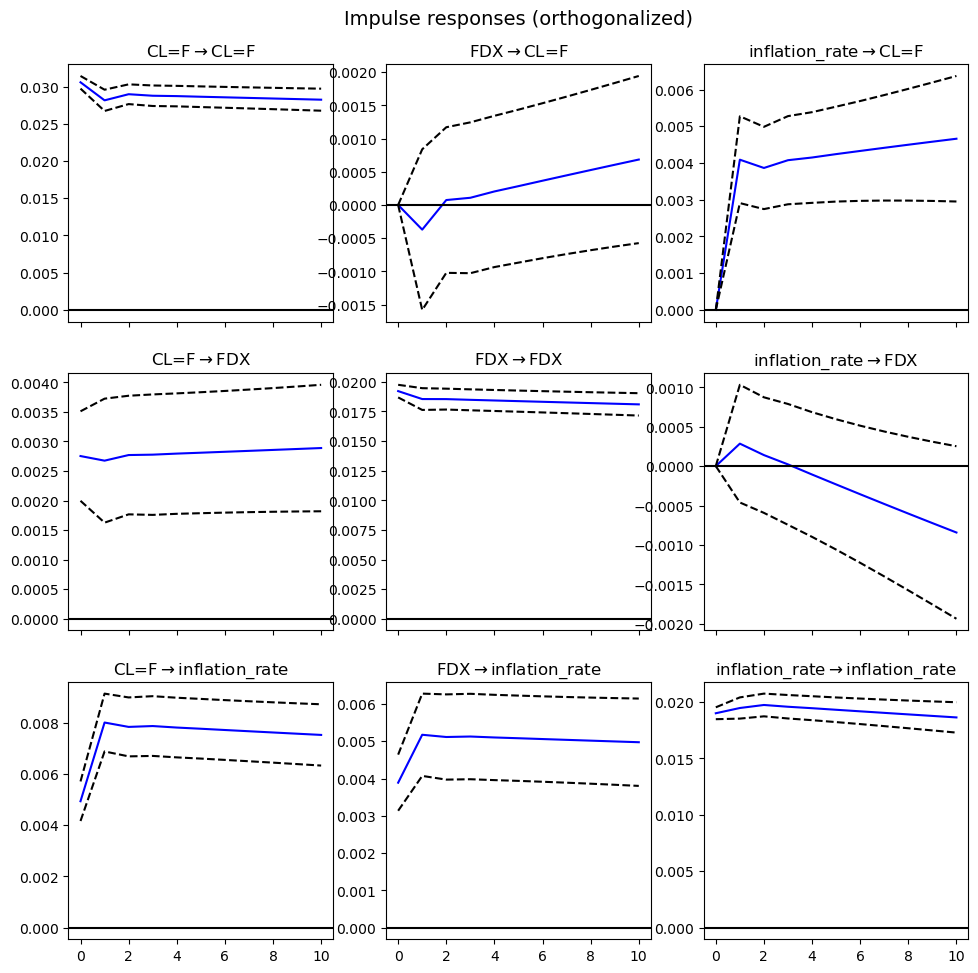

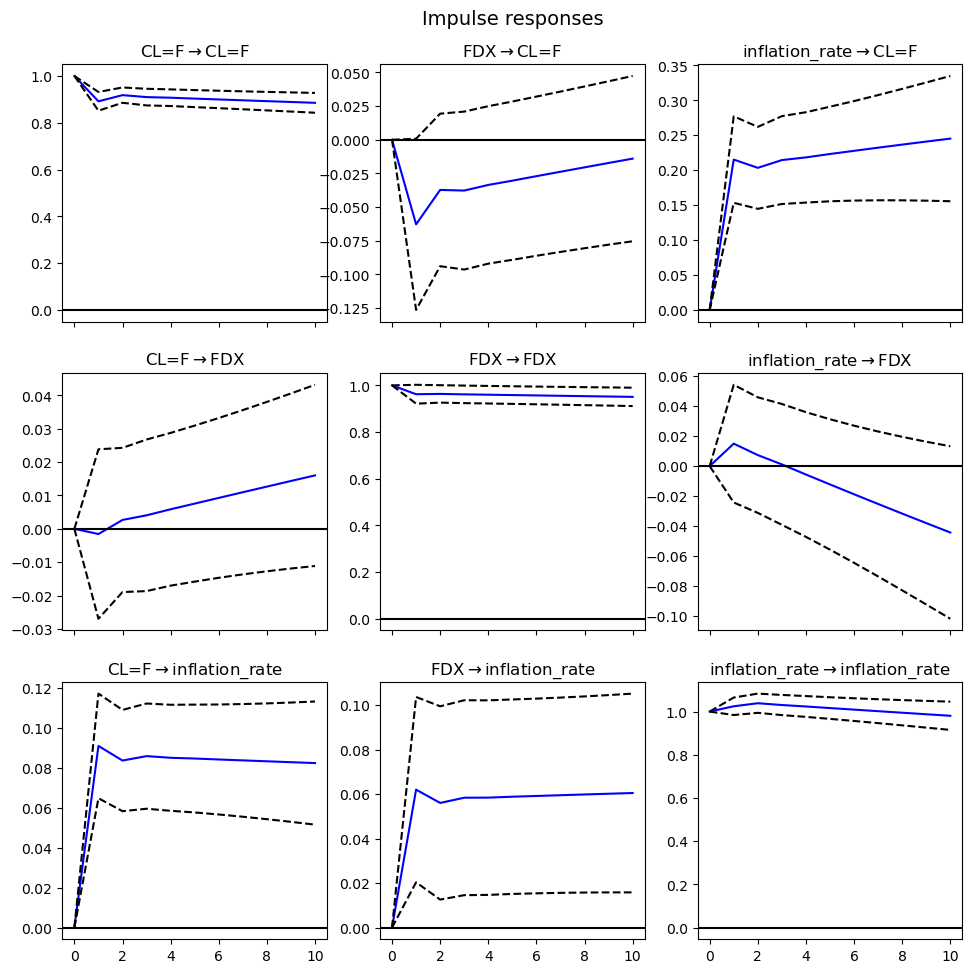

In [17]:
import pandas as pd
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

def irf_vecm(data):

    # Perform Johansen cointegration test to determine the cointegrating rank
    result = coint_johansen(data, det_order=0, k_ar_diff=1)
    # Extract critical values for the test statistics
    trace_stat_crit_vals = result.cvm[:, 0]
    max_eig_stat_crit_vals = result.cvm[:, 1]

    # Extract the test statistics and compare with critical values
    trace_stat = result.lr1
    max_eig_stat = result.lr2
    
    # Determine the rank (number of cointegrating relationships)
    rank = np.sum(trace_stat > trace_stat_crit_vals)

    # Fit a VECM model
    vecm_model = VECM(data, k_ar_diff=1, coint_rank=rank)
    vecm_result = vecm_model.fit()

    # Impulse response analysis
    irf = vecm_result.irf(periods=10)
    irf.plot(orth=True, signif=0.05)

    # Plot impulse response functions
    irf.plot()
    plt.show()
    
irf_vecm(df_series_log)

* FDX → CL=F: FedEx's stock price shock appears to have a minimal and slightly positive effect on crude oil prices initially, but this effect seems negligible and not persistent, indicating that FedEx's stock price does not significantly influence crude oil prices.

    
* FDX → CL=F: FedEx's stock price shock appears to have a minimal and slightly positive effect on crude oil prices initially, but this effect seems negligible and not persistent, indicating that FedEx's stock price does not significantly influence crude oil prices.


* Inflation rate → CL=F: A shock to the inflation rate has a positive and growing impact on crude oil prices. This could imply that as inflation increases, so do crude oil prices, which aligns with historical observations where inflation often correlates with rising commodity prices.

    
* CL=F → FDX: A shock in crude oil prices seems to have no significant immediate or long-term effect on the stock price of FedEx. The response is mostly flat, which suggests that crude oil price changes might not be a decisive factor for FedEx's stock performance or that the market has already priced in the expected effects

    
* Inflation rate → FDX: A negative response of FedEx's stock price to inflation rate shocks is observed, which grows more negative over time. This may indicate that higher inflation rates could be perceived negatively for FedEx's stock value, possibly due to concerns about rising costs affecting profitability.

    
* CL=F → Inflation rate: Crude oil price shocks show a positive and slightly increasing impact on the inflation rate. This is consistent with economic theory, as oil prices are a significant component of the cost of goods and can drive inflationary pressures.

    
* FDX → Inflation rate: There is a small positive response of the inflation rate to shocks in FedEx's stock price. This relationship is not typically direct in economic terms, but it could suggest that movements in major company stock prices like FedEx could be associated with broader economic activity that influences inflation.